# 데이터 호출

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import tensorflow as tf
import csv
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from tensorflow.python.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,Dense,Activation,Dropout,MaxPooling2D
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam

In [8]:
def readCsv(path):
    with open (path,'r') as f:
        reader = csv.DictReader(f)
        rows=list(reader)
    #imgs is a numpy array with all the images
    #tgs is a numpy array with the tags of the images

    height=26 # 26 X 34
    width=34
    
    imgs= np.empty((len(list(rows)),height,width,1),dtype=np.uint8)    # numpy.empty(shape, dtype=float, order='C', *, like=None)
    tgs=np.empty((len(list(rows)),1))
    imgs_flip= np.empty((len(list(rows)),height,width,1),dtype=np.uint8) # 좌우반전

    for row,i in zip(rows,range(len(rows))):
        #convert the list back to the image format

        img= row['image']
        img=img.strip('[').strip(']').split(',')

        # rows= OrderedDict([('state', 'open'),
        #       ('image',
        #        '[88, 91, 95, 99, 102, 106, 109, 110, 113, 114, 118, 122, 123, 125, 126, 124, 125, 123, 124, 123, 120, 114, 117, 112, 108, 105, 100......)

        im=np.array(img,dtype=np.uint8) # uint8	부호 없는(unsigned) 8비트, 1바이트 정수	0 ~ 255
        im=im.reshape((26,34))
        im=np.expand_dims(im,axis=2) # 3차원 추가(1= 흑백)
        imgs[i]=im
        imgs_flip[i]=np.fliplr(im)

        #the tag for open is 1 and for close is 0

        tag= row['state']
        if tag == 'open':
            tgs[i]=1
        else:
            tgs[i]=0
    # 좌우 반전
    imgs_concat=np.concatenate((imgs,imgs_flip))
    tgs_concat=np.concatenate((tgs,tgs))

    #return images and their respective tags
    return imgs_concat , tgs_concat

In [9]:
X,y=readCsv('/content/drive/MyDrive/Colab Notebooks/업로드용 자료/dataset.csv')

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
X_train.shape ,y_train.shape,X_val.shape ,y_val.shape

((4598, 26, 34, 1), (4598, 1), (1150, 26, 34, 1), (1150, 1))

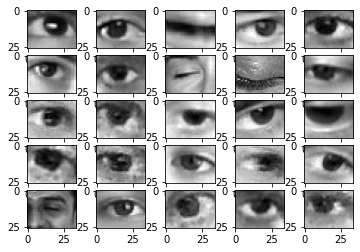

In [12]:
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[i].reshape((26, 34)), cmap='gray') # (26,34,1)이라서 (26,34)로 변경해준다

# Data Augmentation

In [13]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,

)

datagen_val=ImageDataGenerator(rescale=1./255)

train_gen= datagen.flow(
    x=X_train, y=y_train,
    batch_size=32,
    shuffle=False
)

val_gen=datagen_val.flow(
    x=X_val,y=y_val,
    batch_size=32,
    shuffle=False
)

# Modeling

In [15]:
model=tf.keras.Sequential()
model.add(Conv2D(32,(3,3),padding='same',activation='relu',strides=1,input_shape = (26, 34, 1))
)
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),padding='same',activation='relu',strides=1))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),padding='same',activation='relu',strides=1))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
model.fit(train_gen,epochs=50,validation_data=val_gen)

Epoch 1/50
144/144 [==============================] - 13s 21ms/step - loss: 0.4045 - accuracy: 0.8119 - val_loss: 0.1795 - val_accuracy: 0.9348
Epoch 2/50
144/144 [==============================] - 3s 19ms/step - loss: 0.2086 - accuracy: 0.9237 - val_loss: 0.0830 - val_accuracy: 0.9713
Epoch 3/50
144/144 [==============================] - 3s 18ms/step - loss: 0.1615 - accuracy: 0.9432 - val_loss: 0.0714 - val_accuracy: 0.9739
Epoch 4/50
144/144 [==============================] - 3s 18ms/step - loss: 0.1212 - accuracy: 0.9574 - val_loss: 0.0471 - val_accuracy: 0.9887
Epoch 5/50
144/144 [==============================] - 3s 19ms/step - loss: 0.1030 - accuracy: 0.9639 - val_loss: 0.0451 - val_accuracy: 0.9887
Epoch 6/50
144/144 [==============================] - 3s 19ms/step - loss: 0.0953 - accuracy: 0.9693 - val_loss: 0.0292 - val_accuracy: 0.9948
Epoch 7/50
144/144 [==============================] - 3s 23ms/step - loss: 0.0719 - accuracy: 0.9774 - val_loss: 0.0353 - val_accuracy: 0.992

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 34, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 17, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 17, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 4, 128)        0

test acc: 0.9991304347826087


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


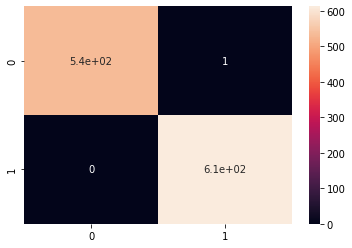

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

y_pred = model.predict(X_val/255.)
y_pred_logical = (y_pred > 0.5).astype(np.int)

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)

In [19]:
model.save('blink_or_not.h5')